In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [154]:
# Imports
from os import makedirs
from os.path import join
import joblib
import numpy as np

rng_seed = 399
np.random.seed(rng_seed)
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, TextArea
import seaborn as sns

sns.set_theme()
from tqdm.auto import tqdm
import pandas as pd
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance

from umap import UMAP
from sklearn.decomposition import PCA
from nltk.corpus import wordnet as wn
import annoy
from sklearn.metrics.pairwise import euclidean_distances

import plotly.offline as pyo

pyo.init_notebook_mode()
import plotly.express as px

# Directory constants
topological_data_analysis_data_dir = "data"
topological_data_analysis_custom_data_dir = "custom_data"
root_code_dir = ".."
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
word2vec_ann_indices_dir = join(output_dir, "word2vec_ann_indices")
word2vec_cluster_analysis_dir = join(output_dir, "word2vec_cluster_analysis")
tps_experimentation_dir = join(output_dir, "topological_polysemy_experimentation")
analysis_of_embeddings_dir = join(root_code_dir, "analysis_of_embeddings")
wme_word2vec_enwiki_dir = join(
    analysis_of_embeddings_dir, "raw_data", "wme_word2vec_enwiki"
)
output_plots_dir = join("output_plots")
makedirs(output_plots_dir, exist_ok=True)

# Extend sys path for importing custom Python files
import sys

sys.path.extend([root_code_dir, analysis_of_embeddings_dir])

from utils import (
    get_model_checkpoint_filepaths,
    pairwise_cosine_distances,
    words_to_vectors,
)
from word_embeddings.word2vec import load_model_training_output
from vis_utils import plot_word_vectors, configure_plotting_for_thesis
from topological_data_analysis.geometric_anomaly_detection import compute_gad
from analysis_utils import transform_word_embeddings

configure_plotting_for_thesis()

Plots configured for thesis!


<IPython.core.display.Javascript object>

## Geometric anomaly detection of the Henneberg data set

In [3]:
# Load Henneberg data
henneberg_data = pd.read_csv(
    join(topological_data_analysis_custom_data_dir, "henneberg.csv"), header=None
).values
henneberg_data_dists = euclidean_distances(henneberg_data)
henneberg_tps_scores = np.load(
    join(tps_experimentation_dir, "henneberg", "tps_scores_50.npy")
)

<IPython.core.display.Javascript object>

In [4]:
henneberg_gad_result = compute_gad(
    data_points=henneberg_data.copy(order="C"),
    manifold_dimension=2,
    annulus_inner_radius=1.5,
    annulus_outer_radius=2,
    data_points_pairwise_distances=henneberg_data_dists,
    progressbar_enabled=True,
    n_jobs=-1,
)

Preparing data for multiprocessing...
Done!
Computing GAD using 20 processes...


<IPython.core.display.Javascript object>

In [5]:
# Create vector with point categories
henneberg_point_categories = np.empty(len(henneberg_data), dtype=object)
for i in range(len(henneberg_data)):
    for key in henneberg_gad_result.keys():
        if i in henneberg_gad_result[key]:
            henneberg_point_categories[i] = key

<IPython.core.display.Javascript object>

In [184]:
gad_categories_to_human_readable = {
    "P_man": "Manifold",
    "P_bnd": "Boundary",
    "P_int": "Singular",
}
gad_color_map = {"P_man": "b", "P_bnd": "g", "P_int": "r"}

<IPython.core.display.Javascript object>

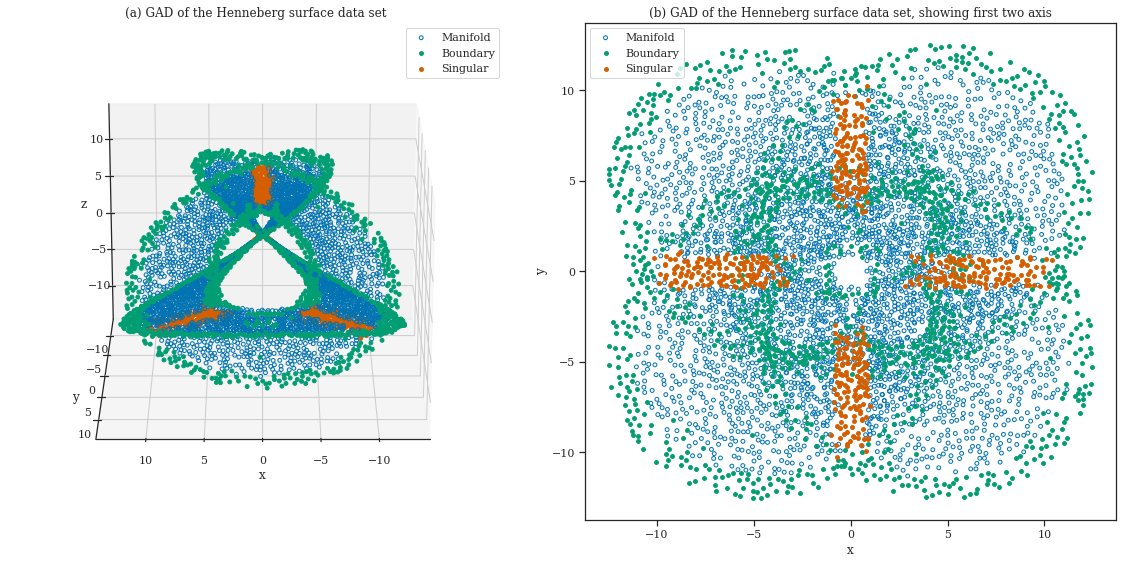

<IPython.core.display.Javascript object>

In [7]:
# Plot Henneberg surface
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2)

for P_category, P_category_color in gad_color_map.items():
    P_category_indices = np.where(henneberg_point_categories == P_category)[0]
    if P_category == "P_man":
        additional_kwargs = {
            "facecolors": "none",
            "edgecolors": "b",
        }
    else:
        additional_kwargs = {
            "c": P_category_color,
        }
    ax1_scatter_handle = ax1.scatter(
        xs=henneberg_data[P_category_indices, 0],
        ys=henneberg_data[P_category_indices, 1],
        zs=henneberg_data[P_category_indices, 2],
        label=gad_categories_to_human_readable[P_category],
        alpha=1,
        s=15,
        **additional_kwargs
    )
    ax1_scatter_handle.set_rasterized(True)
    ax2_scatter_handle = ax2.scatter(
        x=henneberg_data[P_category_indices, 0],
        y=henneberg_data[P_category_indices, 1],
        label=gad_categories_to_human_readable[P_category],
        alpha=1,
        s=15,
        **additional_kwargs
    )
    ax2_scatter_handle.set_rasterized(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.set_title("(a) GAD of the Henneberg surface data set")
ax1.azim = 90
ax1.elev = 20
ax1.legend()
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("(b) GAD of the Henneberg surface data set, showing first two axis")
ax2.legend()

# Plot/save
save_to_pgf = True
plt.tight_layout()
if save_to_pgf:
    plt.savefig(
        join(
            output_plots_dir,
            "gad-henneberg-3d.pdf",
        ),
        backend="pgf",
    )
else:
    plt.show()

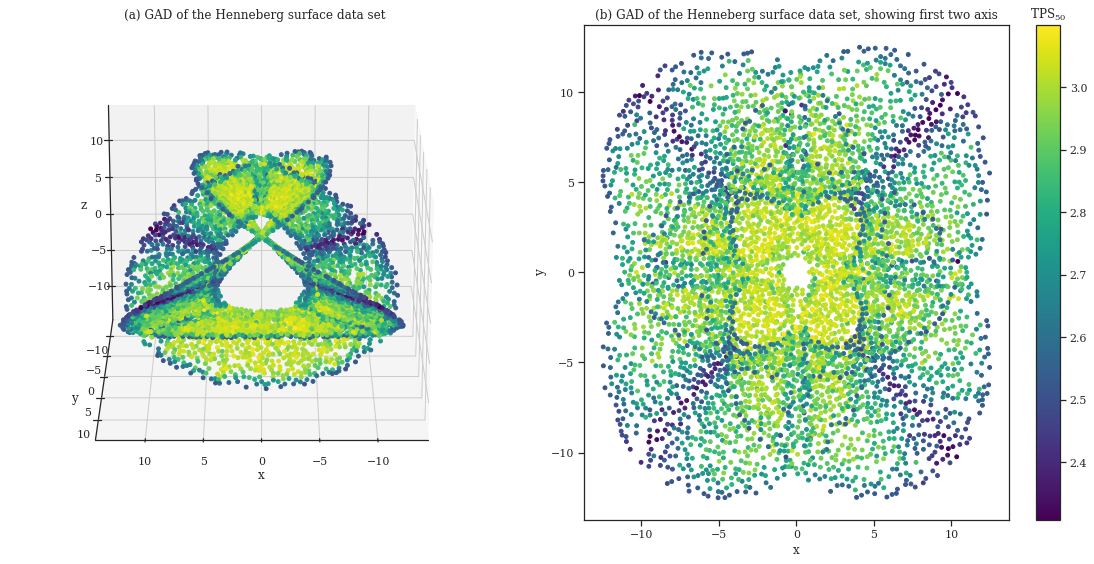

<IPython.core.display.Javascript object>

In [210]:
# Plot Henneberg surface
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2)

for P_category in gad_color_map.keys():
    P_category_indices = np.where(henneberg_point_categories == P_category)[0]
    ax1_scatter_handle = ax1.scatter(
        xs=henneberg_data[P_category_indices, 0],
        ys=henneberg_data[P_category_indices, 1],
        zs=henneberg_data[P_category_indices, 2],
        c=henneberg_tps_scores[P_category_indices],
        alpha=1,
        s=15,
        cmap="viridis",
    )
    ax1_scatter_handle.set_rasterized(True)
    ax2_scatter_handle = ax2.scatter(
        x=henneberg_data[P_category_indices, 0],
        y=henneberg_data[P_category_indices, 1],
        c=henneberg_tps_scores[P_category_indices],
        alpha=1,
        s=15,
        cmap="viridis",
    )
    ax2_scatter_handle.set_rasterized(True)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.set_title("(a) GAD of the Henneberg surface data set")
ax1.azim = 90
ax1.elev = 20
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("(b) GAD of the Henneberg surface data set, showing first two axis")
clb = fig.colorbar(ax2_scatter_handle, ax=ax2)
clb.ax.set_title(r"TPS$_{50}$")

# Plot/save
save_to_pgf = True
plt.tight_layout()
if save_to_pgf:
    plt.savefig(
        join(
            output_plots_dir,
            "gad-henneberg-3d-tps-50.pdf",
        ),
        backend="pgf",
    )
else:
    plt.show()

## Geometric anomaly detection of WordNet word embeddings

In [8]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(
        word2vec_training_dir, "word2vec_enwiki_jan_2021_word2phrase"
    ),
    model_name="word2vec",
    dataset_name="enwiki",
    return_normalized_embeddings=True,
    return_scann_instance=True,
)
last_embedding_weights = w2v_training_output["last_embedding_weights"]
last_embedding_weights_normalized = w2v_training_output[
    "last_embedding_weights_normalized"
]
last_embedding_weights_scann_instance = w2v_training_output[
    "last_embedding_weights_scann_instance"
]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]

<IPython.core.display.Javascript object>

In [18]:
compute_words_to_num_meanings = False
if compute_words_to_num_meanings:
    print("Finding words in vocabulary with #Wordnet synsets > 0")
    words_to_num_meanings = {}
    for word in tqdm(words):
        num_synsets = len(wn.synsets(word))
        if num_synsets > 0:
            words_to_num_meanings[word] = num_synsets
    joblib.dump(
        words_to_num_meanings,
        join(topological_data_analysis_data_dir, "word2vec-enwiki-wordnet-dict.joblib"),
    )
else:
    words_to_num_meanings = joblib.load(
        join(topological_data_analysis_data_dir, "word2vec-enwiki-wordnet-dict.joblib")
    )
data_words = np.array(list(words_to_num_meanings.keys()))
data_words_to_full_vocab_ints = np.array([word_to_int[word] for word in data_words])

<IPython.core.display.Javascript object>

In [186]:
# Load and prepeare GAD result from supervised estimation task
enwiki_gad_result = np.load(
    join(wme_word2vec_enwiki_dir, "gad_features", "gad_knn_25_500.npy")
)
gad_categories = {"P_man": 0, "P_bnd": 2, "P_int": 1}
enwiki_gad_result_filtered_categories = {
    P_cat: enwiki_gad_result[:, gad_categories[P_cat]] == 1
    for P_cat, P_cat_idx in gad_categories.items()
}
enwiki_gad_result_filtered_categories_sizes = {
    P_cat: sum(enwiki_gad_result_filtered_categories[P_cat])
    for P_cat in gad_categories.keys()
}

<IPython.core.display.Javascript object>

In [187]:
# Find number of polysemous words for each GAD category
enwiki_gad_result_num_monosemous_words = {}
enwiki_gad_result_num_polysemous_words = {}
for P_cat in gad_categories.keys():
    P_cat_num_word_meanings = np.array(
        [
            words_to_num_meanings[wn_word]
            for wn_word in data_words[enwiki_gad_result_filtered_categories[P_cat]]
        ]
    )
    enwiki_gad_result_num_monosemous_words[P_cat] = sum(P_cat_num_word_meanings == 1)
    enwiki_gad_result_num_polysemous_words[P_cat] = sum(P_cat_num_word_meanings > 1)

<IPython.core.display.Javascript object>

In [188]:
# Create table
gad_poly_df_dict = {
    "Manifold": [
        enwiki_gad_result_num_monosemous_words["P_man"],
        enwiki_gad_result_num_polysemous_words["P_man"],
    ],
    "Boundary": [
        enwiki_gad_result_num_monosemous_words["P_bnd"],
        enwiki_gad_result_num_polysemous_words["P_bnd"],
    ],
    "Singular": [
        enwiki_gad_result_num_monosemous_words["P_int"],
        enwiki_gad_result_num_polysemous_words["P_int"],
    ],
}
pd.DataFrame(gad_poly_df_dict, index=["# monosemous words", "# polysemous words"])

Manifold  Boundary  Singular
# monosemous words      4640     86731      4161
# polysemous words       634     47902       344

<IPython.core.display.Javascript object>

In [191]:
# Create UMAP embedding
num_top_points = 10000
last_embedding_weights_normalized_10k_wordnet = last_embedding_weights_normalized[
    data_words_to_full_vocab_ints[:num_top_points]
]
last_embedding_weights_10k_wordnet_umap_2d = UMAP(
    n_components=2, random_state=rng_seed
).fit_transform(last_embedding_weights_normalized_10k_wordnet)

<IPython.core.display.Javascript object>

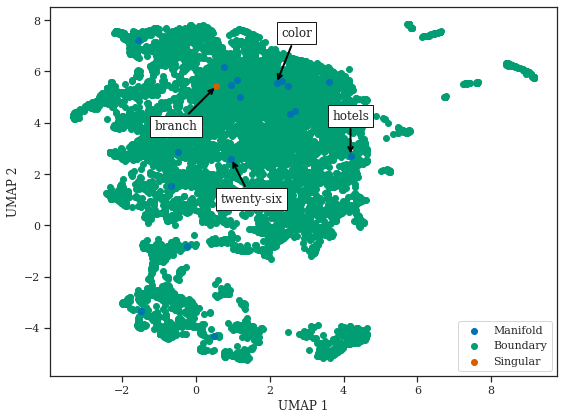

<IPython.core.display.Javascript object>

In [192]:
# Create UMAP plot
_, ax1 = plt.subplots(figsize=(8, 6))

umap_gad_categories_z_order = {"P_man": 1, "P_int": 2, "P_bnd": 0}
for P_cat, P_cat_filter in enwiki_gad_result_filtered_categories.items():
    ax1_scatter_handle = ax1.scatter(
        last_embedding_weights_10k_wordnet_umap_2d[P_cat_filter[:num_top_points], 0],
        last_embedding_weights_10k_wordnet_umap_2d[P_cat_filter[:num_top_points], 1],
        label=gad_categories_to_human_readable[P_cat],
        zorder=umap_gad_categories_z_order[P_cat],
        c=gad_color_map[P_cat],
    )
    ax1.set_xlabel("UMAP 1")
    ax1.set_ylabel("UMAP 2")
    ax1.legend(loc="lower right")
    if sum(P_cat_filter[:num_top_points]) > 1000:
        ax1_scatter_handle.set_rasterized(True)

emphasis_words = [
    ("branch", -40, -80),
    ("color", 20, 10),
    ("twenty-six", 20, -80),
    ("hotels", 0, 0),
]
for emphasis_word, x_offset, y_offset in emphasis_words:
    emphasis_word_idx = word_to_int[emphasis_word]

    # Annotate emphasis word with a text box
    offsetbox = TextArea(emphasis_word)
    ab = AnnotationBbox(
        offsetbox,
        tuple(last_embedding_weights_10k_wordnet_umap_2d[emphasis_word_idx]),
        xybox=(x_offset, 40 + y_offset),
        xycoords="data",
        boxcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="black", linewidth=2),
    )
    ax1.add_artist(ab)

# Plot/save
save_to_pgf = True
plt.tight_layout()
if save_to_pgf:
    plt.savefig(
        join(
            output_plots_dir,
            "gad-umap-2d-10k-most-common-wordnet-enwiki-words.pdf",
        ),
        backend="pgf",
    )
else:
    plt.show()